<a href="https://colab.research.google.com/github/ritikraj660/Speaker-recognition/blob/master/Speaker_Classification_v3_40.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing Packages:

In [1]:
!pip install --upgrade tensorflow-gpu

Requirement already up-to-date: tensorflow-gpu in /usr/local/lib/python3.6/dist-packages (2.1.0)


In [0]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [3]:
!pip install soundfile
!pip install spafe

In [4]:
import tensorflow
tensorflow.test.gpu_device_name() 

'/device:GPU:0'

# Import Packages

In [5]:
import librosa
import soundfile
import tqdm
from scipy.io import wavfile
import glob
import os,pickle
import numpy as np
from spafe.features.mfcc import mfcc, imfcc
import csv
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import numpy as np
import keras
from keras.models import Sequential
#from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D,Dropout
from keras.callbacks import ModelCheckpoint
from keras.models import model_from_json
from keras import backend as K

Using TensorFlow backend.


# Import Data from Drive :

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [8]:
link = 'https://drive.google.com/open?id=1-jhCnWc1Pg5PKjY1aME8JwsVHXljmjFF'
fluff, id = link.split('=')
print (id) 

1-jhCnWc1Pg5PKjY1aME8JwsVHXljmjFF


In [0]:
import pandas as pd
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('LibriSpeech.rar')  

# Extracting Data from (.)rar

In [10]:
!pip install patool

In [11]:
import os
os.listdir()

['.config',
 'LibriSpeech.rar',
 'adc.json',
 'Model.v_2.hdf5',
 'LibriSpeech',
 'sample_data']

In [12]:
%%time
import patoolib
patoolib.extract_archive("LibriSpeech.rar")

patool: Extracting LibriSpeech.rar ...
patool: running /usr/bin/unrar x -- /content/LibriSpeech.rar
patool:     with cwd='./Unpack_wvf7xyde'
patool: ... LibriSpeech.rar extracted to `LibriSpeech1' (local file exists).
CPU times: user 23.9 ms, sys: 32.7 ms, total: 56.6 ms
Wall time: 4.12 s


# Audio Data Preprocessing :

In [0]:
def norm_(x,mean = False):
    if mean == True:
        return (x - np.mean(x)) / (np.max(x) - np.min(x)) #normalization                             
    else:
        return (x-np.mean(x)/np.std(x)) #standardization

def zero_handling(x):
    """
    handle the issue with zero values if they are exposed to become an argument
    for any log function.

    Returns:
        vector with zeros substituted with epsilon values.
    """
    return np.where(x == float(0), np.finfo(float).eps, x)

In [0]:
def mfcc_(sig,fs):
    mfccs  = mfcc(sig, fs=fs, num_ceps=20, pre_emph=1, pre_emph_coeff=0.95, 
              win_len=0.025, win_hop=0.01, win_type='hamming', nfilts=26, 
              nfft=512, low_freq=None, high_freq=None, scale='constant', 
              dct_type=2, use_energy=False, lifter=22)
    #print(fs)
    return mfccs

In [0]:
def label(user,total): # its creating lable for splited audio data
    k_train = []
    for i in range(total):
        k_train.append(user)
    y_train=np.array(k_train).T
    return y_train

In [0]:
from pathlib import Path

#for file_path in Path('LibriSpeech/test-clean').glob('**/*.flac'):
#     print(file_path)

In [0]:
def s2c(mfcc=False,lpcc=False):
    x,y=[],[]
    data = np.empty([1,148,20])
    data_label = np.asarray([])
    count =0  # E:\dataset\LibriSpeech\dev-clean
    #for file in tqdm(glob.iglob('/LibriSpeech/test-clean//**/*.flac', recursive=True)):
    for file in tqdm(Path('LibriSpeech/test-clean').glob('**/*.flac')):
        file_name=os.path.basename(file)
        user = file_name.split("-")[0]
        #print(f)
        with soundfile.SoundFile(file) as sound_file:
                signal = sound_file.read(dtype="float32")
                sr=sound_file.samplerate
        signal = norm_(signal,mean = False)
        signal = zero_handling(signal)
        
        if mfcc:
            feature = mfcc_(signal,sr)
            #print(feature.shape[0])
        if lpcc:
            feature = lpcc_(signal,sr)   
        #if feature.shape[0]>256:
        
        quotient = int(feature.shape[0]/148)
        end_index = feature.shape[0]-(feature.shape[0]%148)
        r = feature[0:end_index,:]
        re_data = np.reshape(r,(-1,148,20))#b = np.reshape(a, (8, 3, -1))
        data=np.concatenate((data,re_data),axis=0)
        
        re_label = label(user,quotient)
        data_label = np.concatenate((data_label,re_label),axis=0)
    return data[1:,:,:],data_label

In [18]:
%%time
def write_(x,y):
    with open('mfcc_data.csv', 'a') as mfcc_dataFile:
        writer = csv.writer(mfcc_dataFile)
        writer.writerows(x)
    mfcc_dataFile.close()
    with open('mfcc_label.csv', 'a') as mfcc_labelFile:
        writer = csv.writer(mfcc_labelFile)
        writer.writerows(y)
    mfcc_labelFile.close()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.48 µs


In [19]:
%%time
x,y = s2c(mfcc=True,lpcc=False)

#write_(x,y)
print(x.shape,y.shape)


u = np.unique(y)
num_classes = len(u)
#print(u)
d = dict()
for enu,key in enumerate(u,0):
    d[key]=enu
print(d)
for i in range(len(y)):
    y[i] = d[y[i]]

2620it [02:47, 10.81it/s]


(11806, 148, 20) (11806,)
{'1089': 0, '1188': 1, '121': 2, '1221': 3, '1284': 4, '1320': 5, '1580': 6, '1995': 7, '2094': 8, '2300': 9, '237': 10, '260': 11, '2830': 12, '2961': 13, '3570': 14, '3575': 15, '3729': 16, '4077': 17, '4446': 18, '4507': 19, '4970': 20, '4992': 21, '5105': 22, '5142': 23, '5639': 24, '5683': 25, '61': 26, '672': 27, '6829': 28, '6930': 29, '7021': 30, '7127': 31, '7176': 32, '7729': 33, '8224': 34, '8230': 35, '8455': 36, '8463': 37, '8555': 38, '908': 39}
CPU times: user 3min 4s, sys: 2min 18s, total: 5min 23s
Wall time: 2min 47s


In [20]:
X  = x.reshape(x.shape[0],x.shape[1],x.shape[2],1)
print(X.shape)


y_binary = keras.utils.to_categorical(y, num_classes = num_classes)
print(y_binary.shape)

x_train, x_test, y_train, y_test = train_test_split(X,y_binary ,test_size=0.20, shuffle= True)

print("Training shape: {0}, Training label shape : {1}".format(x_train.shape,y_train.shape))
print("Training shape: {0}, Training label shape : {1}".format(x_test.shape,y_test.shape))

(11806, 148, 20, 1)
(11806, 40)
Training shape: (9444, 148, 20, 1), Training label shape : (9444, 40)
Training shape: (2362, 148, 20, 1), Training label shape : (2362, 40)


# Creating CNN Architecture :

In [21]:
%tensorflow_version 2.x
import tensorflow 
device_name = tensorflow.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

TensorFlow is already loaded. Please restart the runtime to change versions.
Found GPU at: /device:GPU:0


In [22]:
"""%%time
import numpy as np
#import tensorflow.device('/device:GPU:0')
import tensorflow.python.keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Flatten
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam

model2 = Sequential()
# input: 100x100 images with 3 channels -> (100, 100, 3) tensors.
# this applies 32 convolution filters of size 3x3 each.
model2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(x.shape[1],x.shape[2],1)))

model2.add(Conv2D(32, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.5))

model2.add(Conv2D(64, (3, 3), activation='relu'))

model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.5))
model2.add(Flatten())

model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.5))

model2.add(Dense(40, activation='softmax'))

model2.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
print(model2.summary())#Train and Test The Model
"""

'%%time\nimport numpy as np\n#import tensorflow.device(\'/device:GPU:0\')\nimport tensorflow.python.keras\nfrom tensorflow.python.keras.models import Sequential\nfrom tensorflow.python.keras.layers import Dense, Dropout, Flatten\nfrom tensorflow.python.keras.layers import Conv2D, MaxPooling2D\nfrom keras.optimizers import Adam\n\nmodel2 = Sequential()\n# input: 100x100 images with 3 channels -> (100, 100, 3) tensors.\n# this applies 32 convolution filters of size 3x3 each.\nmodel2.add(Conv2D(32, (3, 3), activation=\'relu\', input_shape=(x.shape[1],x.shape[2],1)))\n\nmodel2.add(Conv2D(32, (3, 3), activation=\'relu\'))\nmodel2.add(MaxPooling2D(pool_size=(2, 2)))\nmodel2.add(Dropout(0.5))\n\nmodel2.add(Conv2D(64, (3, 3), activation=\'relu\'))\n\nmodel2.add(Conv2D(64, (3, 3), activation=\'relu\'))\nmodel2.add(MaxPooling2D(pool_size=(2, 2)))\nmodel2.add(Dropout(0.5))\nmodel2.add(Flatten())\n\nmodel2.add(Dense(256, activation=\'relu\'))\nmodel2.add(Dropout(0.5))\n\nmodel2.add(Dense(40, activ

In [23]:

import numpy as np
import tensorflow.python.keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam

model = Sequential()
# input: 100x100 images with 3 channels -> (100, 100, 3) tensors.
# this applies 32 convolution filters of size 3x3 each.
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(x.shape[1],x.shape[2],1)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
#model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
#model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
#model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
#model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(40, activation='softmax'))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 146, 18, 32)       320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 144, 16, 32)       9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 72, 8, 32)         0         
_________________________________________________________________
dropout (Dropout)            (None, 72, 8, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 70, 6, 64)         18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 68, 4, 64)         36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 34, 2, 64)         0

In [0]:
%%time
from keras.callbacks import ModelCheckpoint
# Saving the model that performed the best on the validation set
checkpoint = ModelCheckpoint(filepath='Model.v_2.hdf5', save_best_only=True, verbose=0)

# Training the model for 40 epochs
history = model.fit(x_train, y_train, batch_size=64, epochs=200, 
                    validation_data=(x_test, y_test), verbose=1, callbacks=[checkpoint])

In [25]:
# Loading the model that performed the best on the validation set
model.load_weights('Model.v_2.hdf5')

# Testing the model on the Test data
(loss, accuracy) = model.evaluate(x_test, y_test, batch_size=16, verbose=1)

print('Accuracy on test data: {:.2f}%'.format(accuracy * 100))

2362/2362 [==============================] - 1s 287us/sample - loss: 0.5337 - accuracy: 0.8654
Accuracy on test data: 86.54%


# Plotting plot :



1.   **accuracy_plot()** : This function plot graph between train accuracy vs validation/test accuracy
2.   **loss_plot():** This function plot graph between train loss vs validation loss



In [0]:
import keras
from matplotlib import pyplot as plt
def accuracy_plot(history):
    plt.figure(figsize=(12,8))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.grid()
    plt.show()

def loss_plot(history):
    plt.figure(figsize=(12,8))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.grid()
    plt.show()

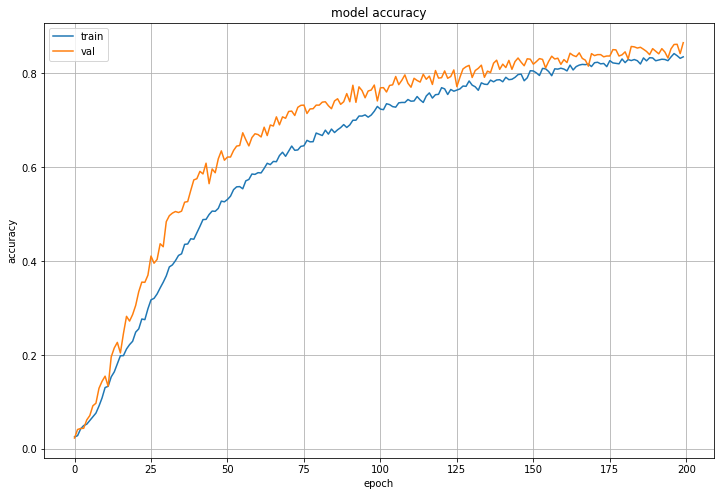

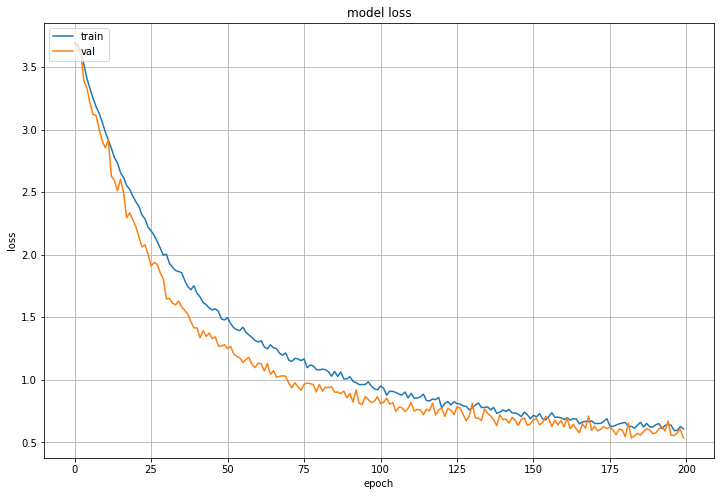

In [27]:

accuracy_plot(history)
loss_plot(history)